A.S. Lundervold, 23.10.2022

# Introduction

When faced with a predictive task based on non-imaging data, an approach that has seen success in certain cases and is therefore worth knowing about and considering is finding a way to **represent your data as images**. 

This makes it possible to use relatively well-developed image analysis techniques in deep learning, for example, those from the landscape surrounding convolutional neural networks.

Of course, this clearly won't make sense in _all_ cases. It can be tricky--or impossible--to capture the information needed to make useful predictions in an image representation in a way that's adapted to the image-based predictive models you'll want to use. 

Still, there are examples of this leading to good results:

For example, an approach to **sound classification**, as used f.ex. for speech recognition, is based on turning audio into spectrograms, e.g., using mel spectrograms to represent speech:

<img width=60% src="assets/melspecs.png">

[Catching fraudsters using their mouse movements](https://www.splunk.com/en_us/blog/security/deep-learning-with-splunk-and-tensorflow-for-security-catching-the-fraudster-in-neural-networks-with-behavioral-biometrics.html) is another interesting example. So is this one: [malware classification](https://ieeexplore.ieee.org/abstract/document/8328749). 

An example of the more general idea of representing **time series data to image data** from my own work is a way to represent **longitudinal measurements** recorded from multiple dementia subjects as greyscale images, one per subject:

<img width=70% src="assets/long_images1.png">

<img src="assets/long_images2.png">

This notebook illustrates the approach on a sound classification data set.

This is to get you thinking about whether transforming data into images and using image-based deep learning models could be helpful in your own work. 

# Setup

In [1]:
# Note: you may disregard these. Added to deal with PyTorch and CUDA version 
# issues on my computer
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA TITAN V'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory, as that makes some difference for the code below.
# We'll do this in every notebook of the course.
if 'google.colab' in str(get_ipython()):
    print('The notebook is running on Colab. colab=True.')
    colab=True
else:
    print('The notebook is not running on Colab. colab=False.')
    colab=False

The notebook is not running on Colab. colab=False.


In [5]:
# Set to True if you're using Paperspace Gradient:
gradient=False

In [6]:
if colab or gradient:
    !pip install -Uqq fastbook
    !pip install -Uqq fastaudio
    import fastbook
    fastbook.setup_book()
    from fastbook import *
    from fastai.vision.all import *
    NB_DIR = Path.cwd()
else:
    from fastai.vision.all import *
    NB_DIR = Path.cwd()
    DATA = Path('/data2/alex/pcs-data')  # Set this to where you want to store downloaded data  
    
if colab:
    DATA = Path('./gdrive/MyDrive/ColabData')
    DATA.mkdir(exist_ok=True)
if gradient:
    DATA = Path('/storage')
    DATA.mkdir(exist_ok=True)

In [7]:
import os, shutil, gc

# Sound classification

<img src="assets/ESC-50.png">

https://github.com/karolpiczak/ESC-50

# Get the data

_Note: the full data set is 600MB. You may want to use the sample data instead_. If you set `sample=True` below, you will use a version of the ESC-50 data set that only has nine classes. 

In [8]:
sample = False

In [9]:
if not colab:

    if sample:
        path = untar_data('https://www.dropbox.com/s/iuq72ty8bu1v5nc/ecs50-sample.zip?dl=1', 
                          fname = 'data/ecs50-sample.zip', dest=DATA)
    if not sample:
        path = untar_data('https://github.com/karoldvl/ESC-50/archive/master.zip', 
                          fname=DATA/'master.zip', dest=DATA)
        
if colab:
    if sample:
        path = untar_data('https://www.dropbox.com/s/iuq72ty8bu1v5nc/ecs50-sample.zip?dl=1')
    if not sample:
        path = untar_data('https://github.com/karoldvl/ESC-50/archive/master.zip')

In [10]:
path.ls()

(#11) [Path('/data2/alex/pcs-data/master/audio'),Path('/data2/alex/pcs-data/master/meta'),Path('/data2/alex/pcs-data/master/LICENSE'),Path('/data2/alex/pcs-data/master/.circleci'),Path('/data2/alex/pcs-data/master/.github'),Path('/data2/alex/pcs-data/master/.gitignore'),Path('/data2/alex/pcs-data/master/pytest.ini'),Path('/data2/alex/pcs-data/master/esc50.gif'),Path('/data2/alex/pcs-data/master/requirements.txt'),Path('/data2/alex/pcs-data/master/tests')...]

In [11]:
audio = path/'audio'
if sample:
    df = pd.read_csv(path/'meta'/'esc50-sample.csv')
if not sample:
    df = pd.read_csv(path/'meta'/'esc50.csv')

In [12]:
audio.ls()

(#2000) [Path('/data2/alex/pcs-data/master/audio/4-188293-A-15.wav'),Path('/data2/alex/pcs-data/master/audio/4-182368-A-12.wav'),Path('/data2/alex/pcs-data/master/audio/4-194246-A-13.wav'),Path('/data2/alex/pcs-data/master/audio/4-212698-A-39.wav'),Path('/data2/alex/pcs-data/master/audio/5-207836-A-29.wav'),Path('/data2/alex/pcs-data/master/audio/5-263501-A-25.wav'),Path('/data2/alex/pcs-data/master/audio/1-28135-A-11.wav'),Path('/data2/alex/pcs-data/master/audio/2-166644-A-2.wav'),Path('/data2/alex/pcs-data/master/audio/3-203373-A-39.wav'),Path('/data2/alex/pcs-data/master/audio/1-50623-A-15.wav')...]

In [13]:
df.head()

filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

In [14]:
df.category.value_counts()

dog                 40
glass_breaking      40
drinking_sipping    40
rain                40
insects             40
laughing            40
hen                 40
engine              40
breathing           40
crying_baby         40
hand_saw            40
coughing            40
snoring             40
chirping_birds      40
toilet_flush        40
pig                 40
washing_machine     40
clock_tick          40
sneezing            40
rooster             40
sea_waves           40
siren               40
cat                 40
door_wood_creaks    40
helicopter          40
crackling_fire      40
car_horn            40
brushing_teeth      40
vacuum_cleaner      40
thunderstorm        40
door_wood_knock     40
can_opening         40
crow                40
clapping            40
fireworks           40
chainsaw            40
airplane            40
mouse_click         40
pouring_water       40
train               40
sheep               40
water_drops         40
church_bells        40
clock_alarm

# Explore the data 

The audio files are stored as WAV files. We can work with audio files in Python using the very convenient `librosa` library. 

<img src="https://librosa.org/images/librosa_logo_text.png">

> Below, we'll use the `fastaudio` library, which relies heavily on librosa. 

In [15]:
import librosa

In [16]:
example_fn = audio.ls()[0]
example_fn

Path('/data2/alex/pcs-data/master/audio/4-188293-A-15.wav')

We can load the WAV file and store the waveform in `y` and the sampling rate in `sr`:

In [17]:
y, sr = librosa.load(example_fn)

`y` is then just a Numpy array, and we can work with it as such:

In [18]:
y

array([ 9.6734817e-05, -6.7663117e-05, -3.0129222e-04, ...,
       -3.0325062e-03, -2.9620295e-03, -3.2129355e-03], dtype=float32)

`sr` is a number (extracted from the WAV file):

In [19]:
sr

22050

Here's a plot of `y`:

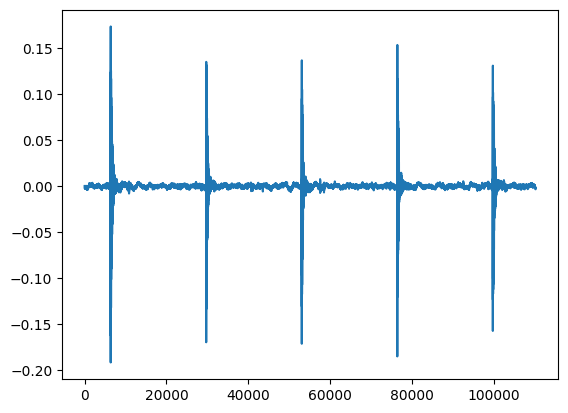

In [20]:
plt.plot(y)
plt.show()

Using the sampling rate we can put the time on the x-axis. This is implemented by librosa's `waveplot`:

In [21]:
from librosa.display import waveplot as waveshow

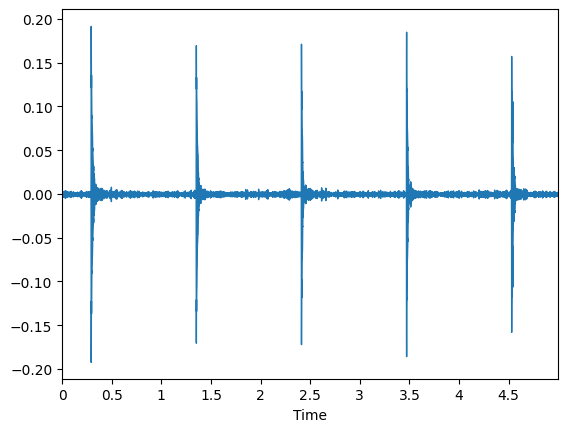

In [22]:
waveshow(y, sr)
plt.show()

Here's a bunch of examples:

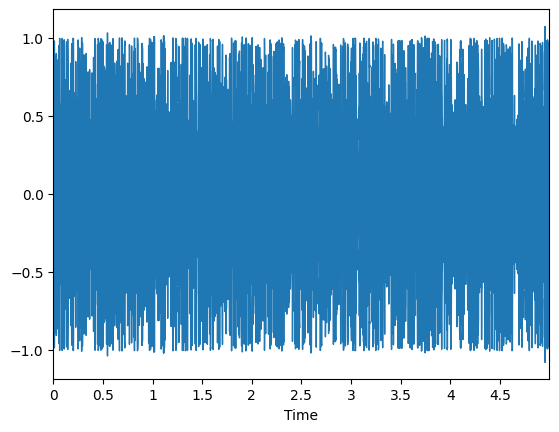

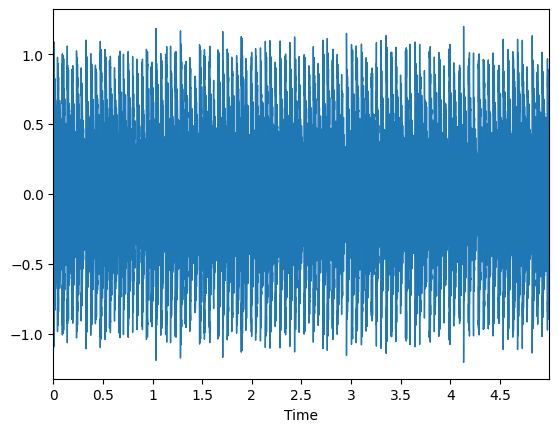

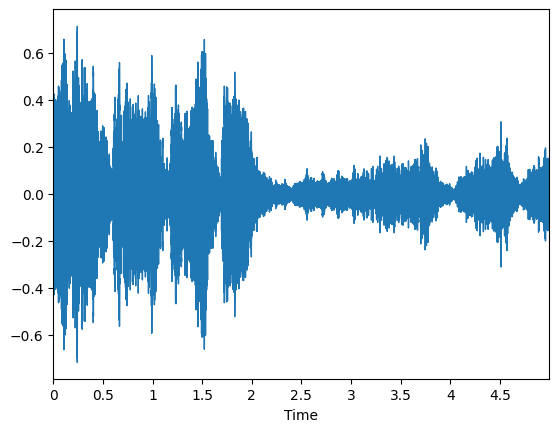

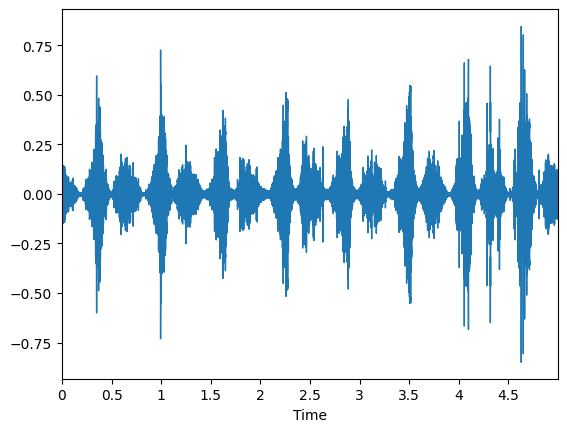

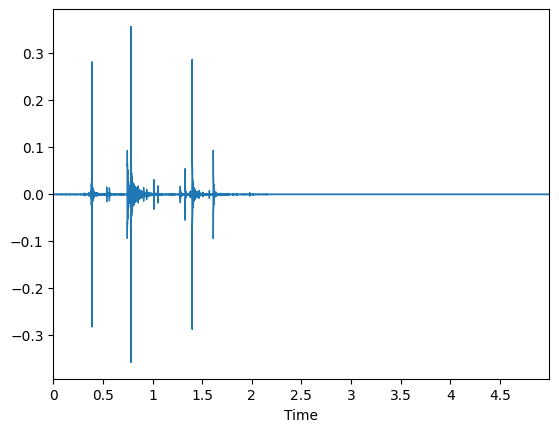

In [23]:
for fn in df.sample(n=5).filename:
    y, sr = librosa.load(audio/fn)
    waveshow(y, sr)
    plt.show()

We can play the audio files via our notebooks using IPython:

In [24]:
from IPython.display import Audio, display

In [25]:
Audio(example_fn)

In [26]:
def plot_play_clip(i, audio_list):
    fn = audio/audio_list[i]
    a, sr = librosa.load(fn)
    fn_class = df.loc[df.filename==f'{fn.stem}.wav'].category.values[0]
    waveshow(a, sr)
    plt.title(fn_class)
    plt.show()
    display(Audio(a, rate=sr))
    return None

In [27]:
import ipywidgets as widgets

In [28]:
from ipywidgets import interactive, fixed

In [29]:
interactive_plot = interactive(plot_play_clip, 
                              i=widgets.BoundedIntText(min=0, max=50, step=1, value=0),
                              audio_list=fixed(audio.ls()))

In [30]:
interactive_plot

interactive(children=(BoundedIntText(value=0, description='i', max=50), Output()), _dom_classes=('widget-inter…

We can try to get a sense of the variation in the data by listening to some examples from specific categories:

In [31]:
def random_category_examples(c, k=5):
    relevant = df.loc[df.category==c]
    for i in range(k):
        fn = relevant.iloc[i].filename
    return relevant.sample(n=k)

In [32]:
df.category.value_counts()

dog                 40
glass_breaking      40
drinking_sipping    40
rain                40
insects             40
laughing            40
hen                 40
engine              40
breathing           40
crying_baby         40
hand_saw            40
coughing            40
snoring             40
chirping_birds      40
toilet_flush        40
pig                 40
washing_machine     40
clock_tick          40
sneezing            40
rooster             40
sea_waves           40
siren               40
cat                 40
door_wood_creaks    40
helicopter          40
crackling_fire      40
car_horn            40
brushing_teeth      40
vacuum_cleaner      40
thunderstorm        40
door_wood_knock     40
can_opening         40
crow                40
clapping            40
fireworks           40
chainsaw            40
airplane            40
mouse_click         40
pouring_water       40
train               40
sheep               40
water_drops         40
church_bells        40
clock_alarm

In [33]:
examples = random_category_examples('crow')
examples

filename  fold  target category  esc10  src_file take
341    1-75162-A-9.wav     1       9     crow  False     75162    A
8     1-103298-A-9.wav     1       9     crow  False    103298    A
1809  5-213836-C-9.wav     5       9     crow  False    213836    C
455   2-108767-C-9.wav     2       9     crow  False    108767    C
1815  5-214869-A-9.wav     5       9     crow  False    214869    A

In [34]:
examples_fns = [Path(fn) for fn in examples.filename]

In [35]:
interactive_plot = interactive(plot_play_clip, 
                              i=widgets.BoundedIntText(min=0, max=(len(examples_fns)-1), step=1, value=0),
                              audio_list=fixed(examples_fns))

In [36]:
interactive_plot

interactive(children=(BoundedIntText(value=0, description='i', max=4), Output()), _dom_classes=('widget-intera…

Note that all the audio files are 5 seconds long:

In [37]:
librosa.get_duration(y, sr)

5.0

> This simplifies some things for us. If you're dealing with time series of different lengths you may consider cropping the series or splitting it up in parts. 

# Side-note: General points about time series data

> These audio recordings are examples of (univariate) time series and can be studied and dealt with using what you learned about in time series analysis. 

We'll discuss time series in a later notebook.

# Prepare the data: from WAV to spectograms

In [38]:
if colab or gradient:
    !pip install fastaudio

In [39]:
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

In [40]:
audio.ls()[0]

Path('/data2/alex/pcs-data/master/audio/4-188293-A-15.wav')

In [41]:
at = AudioTensor.create(audio.ls()[0])

<AxesSubplot: >

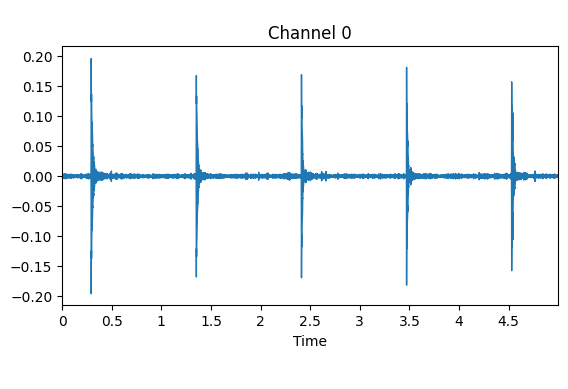

In [42]:
at.show()

In [43]:
?AudioConfig.BasicMelSpectrogram

In [44]:
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512, sample_rate=sr)
a2s = AudioToSpec.from_cfg(cfg)

In [45]:
a2s.settings

{'mel': True,
 'to_db': True,
 'sample_rate': 22050,
 'n_fft': 512,
 'win_length': 512,
 'hop_length': 256,
 'f_min': 0.0,
 'f_max': None,
 'pad': 0,
 'n_mels': 128,
 'window_fn': <function _VariableFunctionsClass.hann_window>,
 'power': 2.0,
 'normalized': False,
 'wkwargs': None,
 'center': True,
 'pad_mode': 'reflect',
 'onesided': True,
 'norm': None,
 'stype': 'power',
 'top_db': None}

<AxesSubplot: >

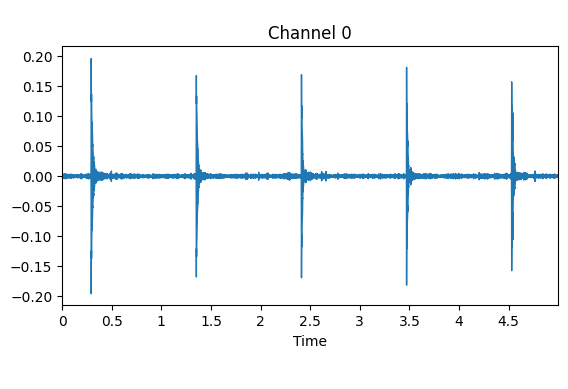

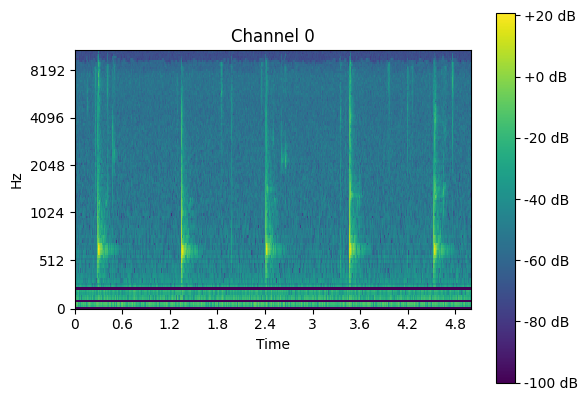

In [46]:
pipeline = Pipeline([AudioTensor.create, a2s])

a = AudioTensor.create(audio.ls()[0])
a.show()
pipeline(audio.ls()[0]).show()

# Split into train-val data

To use the same cross-validation setup as in original paper: 

From https://colab.research.google.com/github/fastaudio/fastaudio/blob/master/docs/ESC50:%20Environmental%20Sound%20Classification.ipynb

In [47]:
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

# Data loaders

**Datablock:**

In [48]:
auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader("filename", pref=audio), 
                 splitter = CrossValidationSplitter(fold=1),
                 batch_tfms = [a2s],
                 get_y = ColReader("category"))

**Dataloader:**

In [49]:
dbunch = auds.dataloaders(df, bs=128)

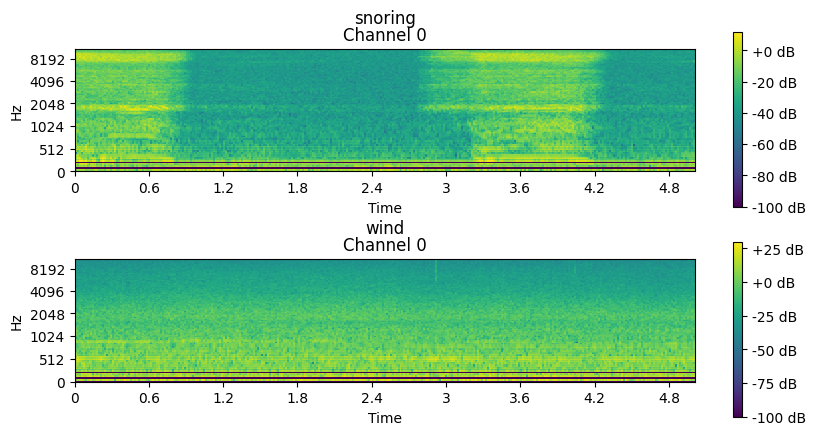

In [53]:
dbunch.show_batch(figsize=(10, 5))

### Training a model

In [55]:
learn = cnn_learner(dbunch, 
            resnet34,
            n_in=1, 
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy])

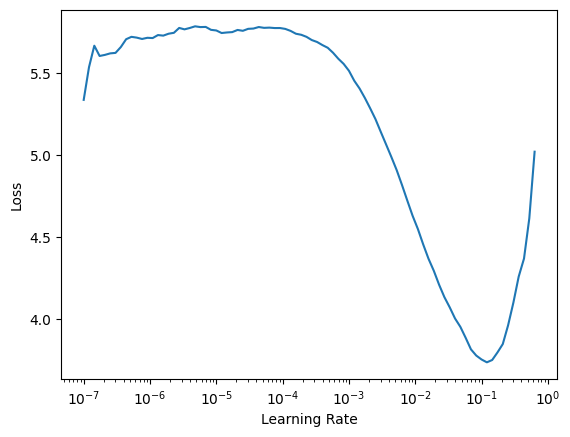

In [56]:
lr = learn.lr_find()

In [57]:
lr

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.0063095735386013985)

In [59]:
learn.fit_one_cycle(10, lr.lr_steep)

# Evaluate the results

Here are some predictions:

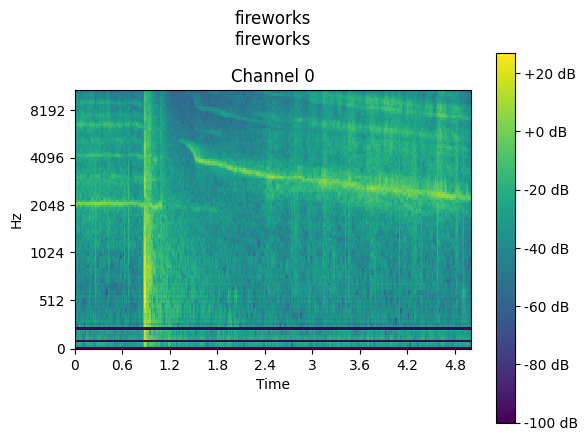

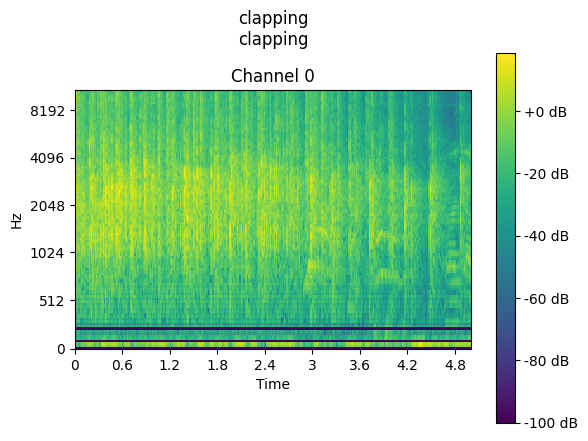

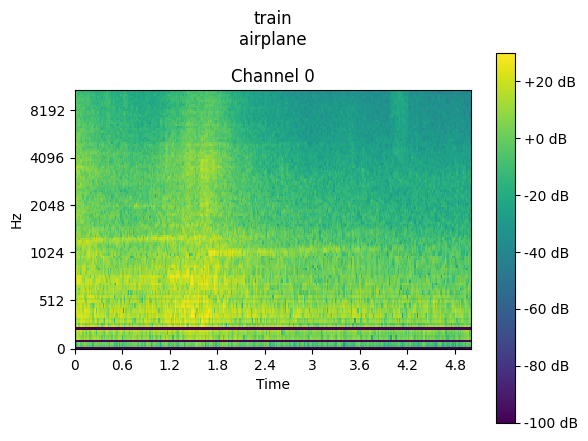

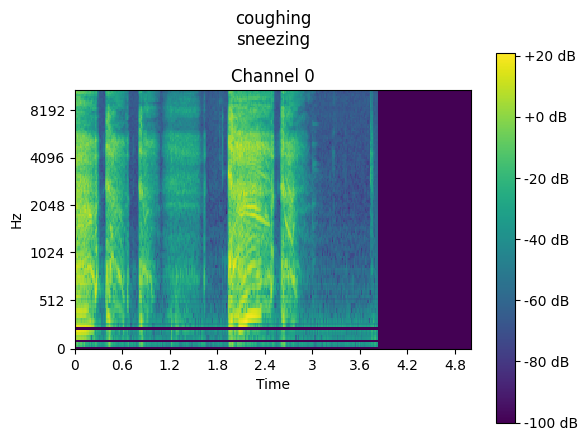

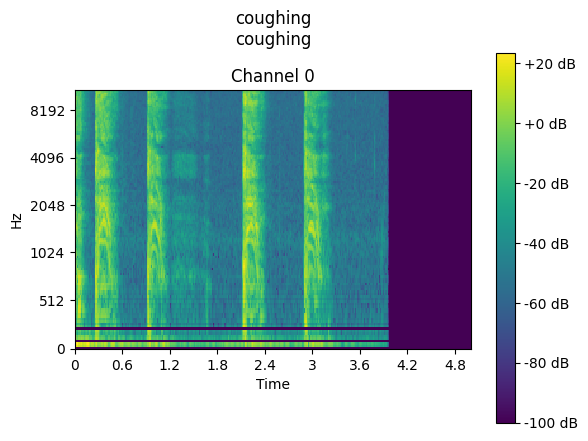

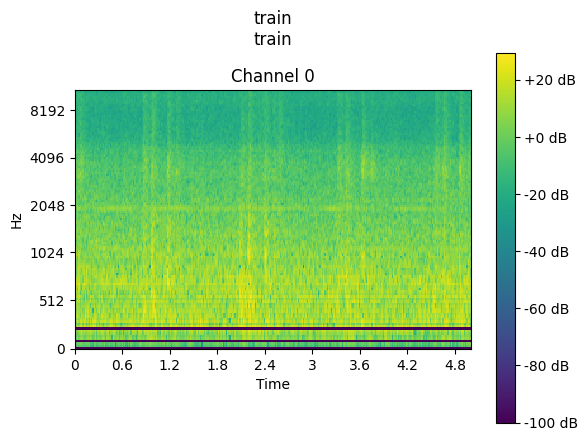

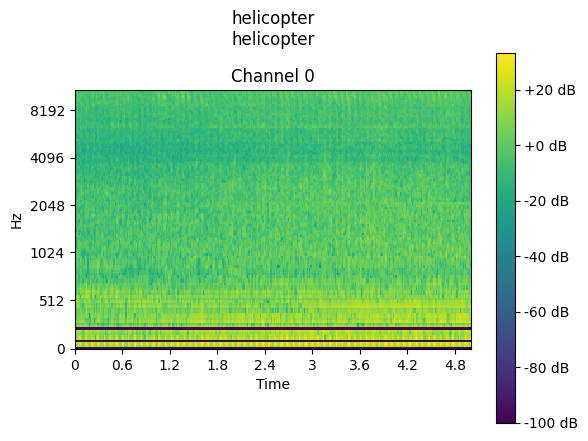

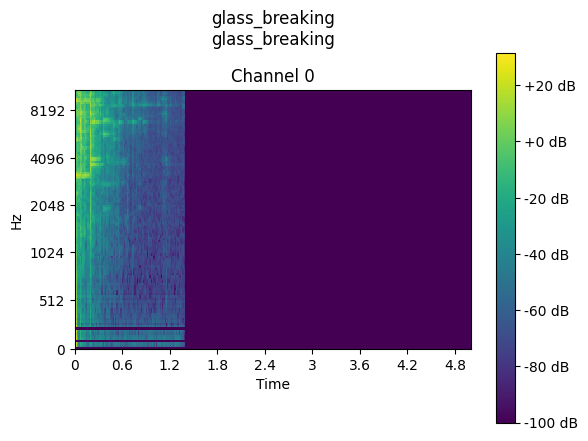

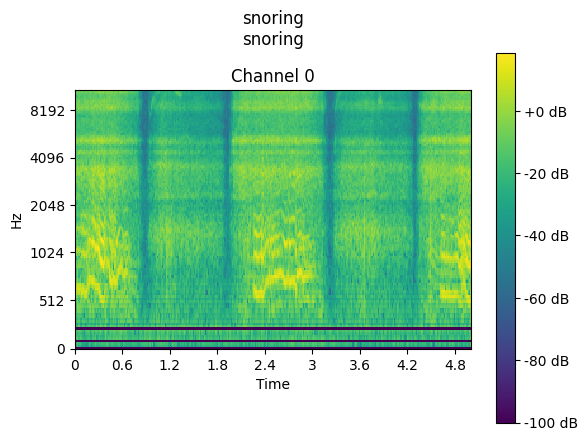

In [60]:
learn.show_results()

Let's count up the mistakes:

In [61]:
interp = ClassificationInterpretation.from_learner(learn)

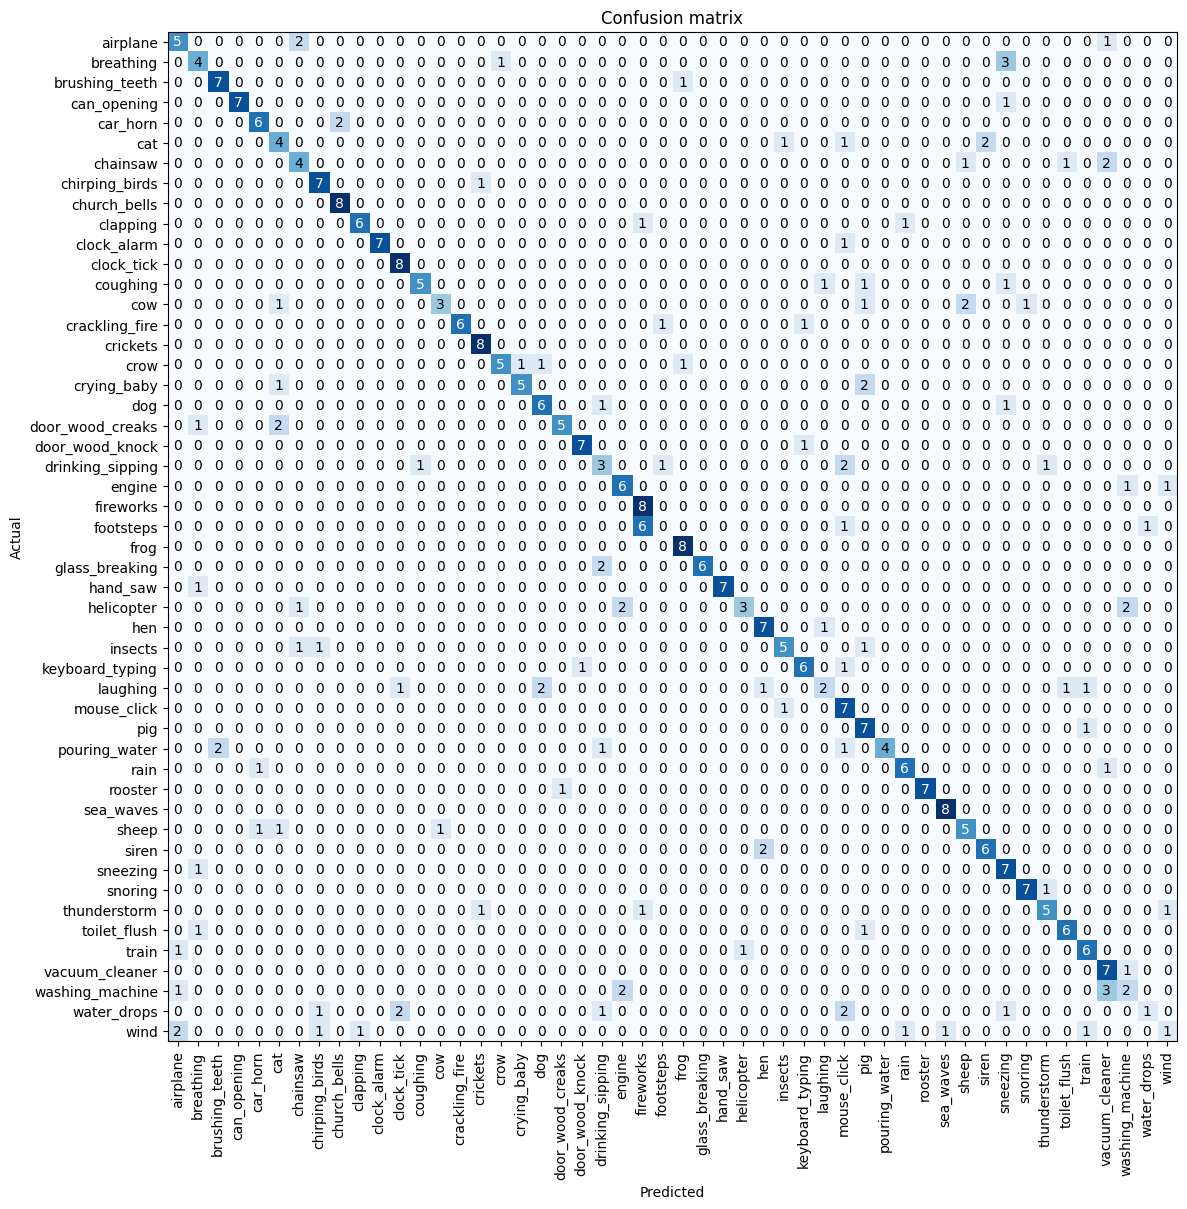

In [62]:
interp.plot_confusion_matrix(figsize=(12,12))

Not too bad. How does this compare to other researchers working on the same data set? To answer that, we need to expand our evaluation somewhat as we should use the exact same data for evaluating our models.

## Comparing our results to those of others

Let's make a function that performs the steps above, but on different validation folds (i.e. the same cross-validation setup as in the original paper):

In [65]:
def train_model(fold, auds=auds, epochs=10, bs=128, 
                arch=resnet34,
                item_tfms=None, n_in=1, callbacks = None):
    
    # Set up the data
    auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader("filename", pref=audio), 
                 splitter = CrossValidationSplitter(fold=fold),
                 item_tfms = item_tfms,
                 batch_tfms = [a2s],
                 get_y = ColReader("category"))
    dbunch = auds.dataloaders(df, bs=bs)
   
    # Create the model
    learn = cnn_learner(dbunch, arch, n_in=n_in,
                        loss_func=CrossEntropyLossFlat(), 
                        metrics=[accuracy], cbs=callbacks
                       )
    
    # Find a learning rate
    lr = learn.lr_find(show_plot=False)
    
    # Train the model
    learn.fit_one_cycle(epochs, lr.lr_steep)
    
    # Return the accuracy of the model on the validation data
    return learn.metrics[0].value

The training process takes some time. We can load the outputs as images below. 

In [66]:
# We train the model on all five folds specified by the creators of the data set
accs = []
for fold in df.fold.unique():
    accs.append(train_model(fold, epochs=10))

In [ ]:
from IPython.display import display, Image
display(Image('https://github.com/alu042/PCS956-DL-2022/raw/master/2-intro_to_practical_dl/assets/audio_init_crossval.png'))

In [67]:
accs

[TensorBase(0.7075),
 TensorBase(0.6925),
 TensorBase(0.7175),
 TensorBase(0.7475),
 TensorBase(0.6650)]

In [68]:
# Average accuracy across the folds:
np.array(accs).sum()/len(df.fold.unique())

0.7059999465942383

How does it compare to others? 

https://github.com/karolpiczak/ESC-50#results

We're at the level of [this poster](https://www.mi.t.u-tokyo.ac.jp/assets/publication/LEARNING_ENVIRONMENTAL_SOUNDS_WITH_END-TO-END_CONVOLUTIONAL_NEURAL_NETWORK-poster.pdf) submitted to the 2017 IEEE International Conference on Acoustics, Speech and Signal Processing (71%). Not too bad for such a simple setup, but, still, quite far from the top... 

# Improving our results

## Data augmentation

There are many approaches one could pursue for data augmentation in audio, from simple things like adding various forms of noise at random, resampling at random, or changing the pitch and speed, to more advanced ideas like [masking blocks of time-steps or frequencies](https://arxiv.org/abs/1904.08779).

Let's try a few of those propsed in the paper linked above. They come built-in to `fastaudio`.

In [69]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

In [70]:
aud2spec = DBMelSpec(sample_rate=sr, n_mels=128, n_fft=512, hop_length=128)

In [71]:
aud2spec.settings

{'mel': True,
 'to_db': True,
 'sample_rate': 22050,
 'n_fft': 512,
 'win_length': 512,
 'hop_length': 128,
 'f_min': 0.0,
 'f_max': None,
 'pad': 0,
 'n_mels': 128,
 'window_fn': <function _VariableFunctionsClass.hann_window>,
 'power': 2.0,
 'normalized': False,
 'wkwargs': None,
 'center': True,
 'pad_mode': 'reflect',
 'onesided': True,
 'norm': None,
 'stype': 'power',
 'top_db': None}

In [72]:
item_tfms = [aud2spec, MaskTime(size=4), MaskFreq(size=10)]

Here are some images showing the effect of the data augmentations (for the plots, we've made the data augmentation more pronounced for illustration purposes):

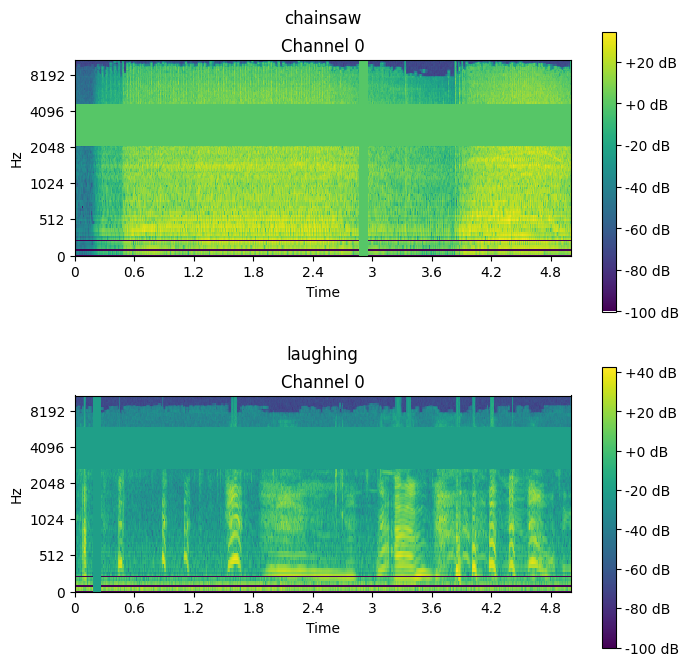

In [74]:
auds.item_tfms = [aud2spec, MaskTime(size=30), MaskFreq(size=30)]
dls = auds.dataloaders(df, bs=128)
dls.show_batch(max_n=2, figsize=(8,8))

You notice the deleted temporal parts and the deleted frequencies.

Note: Again, the training takes some time and we can rather load the outputs from a previous round.

In [76]:
# We train for a few additional epochs as we now have (in effect) more data
accs_da = []
for fold in df.fold.unique():
    accs_da.append(train_model(fold, item_tfms=item_tfms, epochs=13))

In [77]:
accs_da

[TensorBase(0.8025),
 TensorBase(0.7400),
 TensorBase(0.7650),
 TensorBase(0.7875),
 TensorBase(0.7250)]

In [78]:
# Average accuracy across the folds:
np.array(accs_da).sum()/len(df.fold.unique())

0.7639999389648438

In [ ]:
from IPython.display import display, Image
display(Image('https://github.com/alu042/PCS956-DL-2022/raw/master/2-intro_to_practical_dl/assets/audio_da_crossval.png'))

A solid improvement over our previous result:

In [83]:
# Our previous result:
np.array(accs).sum()/len(df.fold.unique())

0.6135000228881836

## Adding additional images

Let's try to add _delta_ features as new images. They are computed using an estimate of the _derivatives_ of the first and second order in our signal. 

In [79]:
item_tfms = [aud2spec, MaskTime(size=4), MaskFreq(size=10), Delta()]

Here's the effect of the Delta transformations:

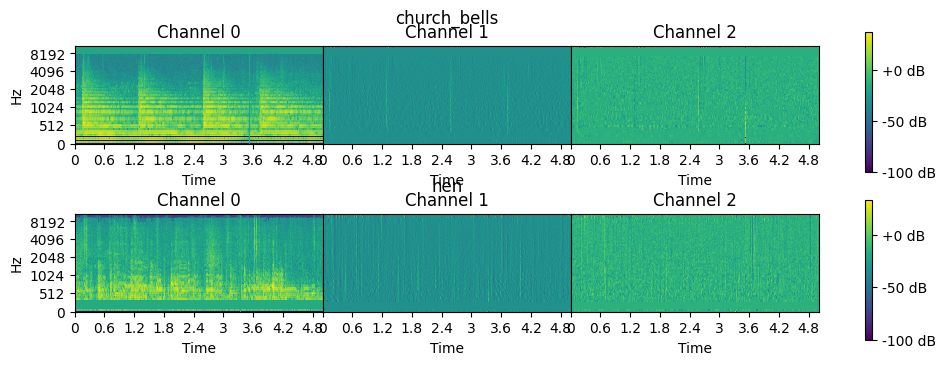

In [80]:
auds.item_tfms = item_tfms
dls = auds.dataloaders(df, bs=128)
dls.show_batch()

We now have three channels instead of one: the original image in channel 0, then the two images obtained from the (approximate) derivatives in the time and the frequency directions in channels 1 and 2.

Let's check if the information from the representations derived from Delta helps our models:

> The training takes a while. You can rather load the training outputs saved as an image below.

In [81]:
# We train for a few additional epochs as we now have (in effect) more data
accs_delta = []
for fold in df.fold.unique():
    accs_delta.append(train_model(fold, item_tfms=item_tfms, epochs=16, n_in=3))

In [82]:
accs_delta

[TensorBase(0.7925),
 TensorBase(0.7600),
 TensorBase(0.7700),
 TensorBase(0.8100),
 TensorBase(0.7725)]

In [83]:
# Average accuracy across the folds:
np.array(accs_delta).sum()/len(df.fold.unique())

0.7809999942779541

In [ ]:
from IPython.display import display, Image
display(Image('https://github.com/alu042/PCS956-DL-2022/raw/master/2-intro_to_practical_dl/assets/audio_delta_crossval.png'))

This result is competitive with the 79.80% obtained in the paper [Look, Listen and Learn](https://openaccess.thecvf.com/content_iccv_2017/html/Arandjelovic_Look_Listen_and_ICCV_2017_paper.html) from ICCV2017 by the two Google DeepMind researchers Relja Arandjelović and Andrew Zisserman (who's also a famous researcher in the VGG group at the University of Oxford). 

### Human performance

In the paper introducing the ECS-50 data set, they reported an experiment where they crowdsourced labels from human listeners. The reported human accuracy was **81,30%** (in their somewhat limited experiment; read [the paper](https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf) for more details). 

### The state-of-the-art

https://github.com/YuanGongND/ast claims an accuracy of 95,70% on the ECS-50 data set.

### An important warning / caveat

The ECS-50 evaluation setup suffers from a common problem across many machine learning data sets used to benchmark and compare models. As _there is no hidden test data that the researchers cannot access until their model's generalization performance is estimated,_ it is very easy to fool yourself into thinking you have better results than you _actually_ have. 

For example, we could train the above model using _early stopping_, i.e., stopping the training when the validation loss is smallest (or close to the smallest). This approach is the same as picking the model from the epoch where the validation loss was smallest during the above training procedure. If we look at the accuracies, we see that we would then be able to make the (**invalid**) accuracy claim of **more than 80%**.

Another way to obtain invalid overestimates of the generalization performance would be to simply run the training above over and over, and then, because of randomness in many parts of the setup (e.g. randomness in initialization of the network weights, randomness in the data augmentation), find a cross-validation run that's better than the one we reported. 

You could also play various model hyperparameters or the data augmentation setup or simply try out a bunch of different number of epochs until you improve the results. 

> Again, I'm not recommending that you do this! It completely invalidates your results!

This issue, which is, again, quite common across machine learning data sets used in research, means that _it should be required that all the source code needed to fully reproduce the results is published along with the papers_. 

> Note: even if the code is shared, you should be vigilant about any sign of tinkering to obtain what seems to be better results but aren't. Like fixed random seeds using `random_state` or similar... Instabilities in the validation loss during the latter parts of the training process, meaning that it fluctuates significantly, can also be a worrying sign. 

# Your turn

> **Your turn!** Several of the tricks presented in the previous notebook can be applied. For example, would ensembling a few models improve the results? What about test-time augmentation? 

> **Your turn!** Perhaps you can think of other image representations? What about wavelets? Does it help to include these as well in the above setup?